In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torch
from src.dataset.dataset import SubCellDatset, DatasetType
import lightning.pytorch as pl
from src.model.full_model import SubCellProtModel
from src.utils.analysis_utils import process_matrix
from src.utils.data_handling_utils import initialize_datasets, Retrieval_Data
from src.utils.batch_run_utils import get_proteoform_data
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pdb

2024-07-03 20:14:52.748211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/xinyi/pups


In [2]:
RANDOM_COLLECTION_NAME="random_splice_isoform_dataset"
COLLECTION_NAME="splice_isoform_dataset_cell_line_and_gene_split_full"

# Control (no threshold)
NO_THRESHOLD_MODEL_CHECKPOINT = "checkpoints/nothreshold.ckpt"
THRESHOLD = None

# Uncomment the next two line and run for the model trained with the threshold
# THRESHOLDED_MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'
# THRESHOLD = 0.19

In [277]:
RANDOM_COLLECTION_NAME="random_splice_isoform_dataset"

random_train_dataset, random_val_dataset, random_test_dataset, random_get_data = (
    initialize_datasets(RANDOM_COLLECTION_NAME, if_alphabetical=False)
)

train_dataset, val_dataset, test_dataset, get_data = initialize_datasets(
    COLLECTION_NAME, if_alphabetical=True
)

In [278]:
loaded_model = SubCellProtModel().load_from_checkpoint(
    NO_THRESHOLD_MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)

number of classes  29
number of classes  29


In [279]:
def get_rby_images(cell_idx, filter_low_values=None):
    """
    Fetches the microtubule (red), nucleui (blue), and endoplasmic reticulum (yellow) stains
    """
    dataset_name, idx = cell_idx.split('_')[0], int(cell_idx.split('_')[1])
    if dataset_name.lower() == DatasetType.TRAIN.name.lower():
        dataset = train_dataset
    elif dataset_name.lower() == DatasetType.TEST.name.lower(): 
        dataset = test_dataset
    elif dataset_name.lower() == DatasetType.EVAL.name.lower(): 
        dataset = val_dataset

    (
        _cell_X_esm2_encoding_orig,
        _cell_X_protein_len_orig,
        X_landmark_stains,
        _cell_y_multilabel_orig,
        _cell_y_antibody_stain_orig,
    ), _cell_line_metadata = dataset.get_item_verbose(idx, filter_low_values=filter_low_values)

    nuclei_img = np.zeros(X_landmark_stains.T.shape)
    nuclei_img[:, :, 2] = X_landmark_stains[0, :, :]
    nuclei_img = Image.fromarray(np.uint8(np.abs(nuclei_img) * 255), mode="RGB")

    microtubule_img = np.zeros(X_landmark_stains.T.shape)
    microtubule_img[:, :, 0] = X_landmark_stains[1, :, :]
    microtubule_img = Image.fromarray(
        np.uint8(np.abs(microtubule_img) * 255), mode="RGB"
    )

    mitochondria_img = np.zeros(X_landmark_stains.T.shape)
    mitochondria_img[:, :, 0] = X_landmark_stains[2, :, :]
    mitochondria_img[:, :, 1] = X_landmark_stains[2, :, :]
    mitochondria_img = Image.fromarray(
        np.uint8(np.abs(mitochondria_img) * 255), mode="RGB"
    )
    return microtubule_img, nuclei_img, mitochondria_img

In [280]:
def viz_matrix_on_fly(
    loaded_model,
    cell_idxs,
    isoform_idxs,
    show_landmark_stains=True,
    show_y_true_on_diagonal=False,
    figsize=(20, 20),
    data_sources=None,
):
    if show_y_true_on_diagonal:
        assert (
            cell_idxs == isoform_idxs
        ), "Only can show y_true on the diagonal if rows & columns are the same"
    fig, axes = plt.subplots(
        nrows=len(cell_idxs),
        ncols=len(isoform_idxs) + (3 if show_landmark_stains else 0),
        figsize=figsize,
        sharex=True,
        sharey=True,
    )

    if show_landmark_stains:
        for row_idx, cell_idx in enumerate(cell_idxs):
            microtubule_img, nuclei_img, mitochondria_img = get_rby_images(cell_idx)
            axes[row_idx, 0].imshow(nuclei_img)
            axes[row_idx, 1].imshow(microtubule_img)
            axes[row_idx, 2].imshow(mitochondria_img)
            if row_idx == 0:
                axes[row_idx, 0].set_title("Nucleus", fontsize=12)
                axes[row_idx, 1].set_title("Microtubule", fontsize=12)
                axes[row_idx, 2].set_title("Endoplasmic Ret.", fontsize=12)

    for row_idx, cell_idx in enumerate(cell_idxs):
        for col_idx, isoform_idx in enumerate(isoform_idxs):
            ax = axes[row_idx, col_idx + (3 if show_landmark_stains else 0)]

            if show_y_true_on_diagonal and row_idx == col_idx:
                if data_sources is not None:
                    data_source = data_sources[row_idx]
                _y_multilabel, y_antibody_stain = data_source(
                    isoform_idx, Retrieval_Data.TRUE_LABELS
                )
                image_data = y_antibody_stain.squeeze()
                y_true_img = np.zeros((image_data.shape[0], image_data.shape[1], 3))
                y_true_img[:, :, 1] = image_data
                y_true_img = Image.fromarray(
                    np.uint8(np.abs(y_true_img) * 255), mode="RGB"
                )
                ax.imshow(y_true_img)
            else:

                if data_sources is not None:
                    cell_data_source = data_sources[row_idx]
                    protein_data_source = data_sources[col_idx]
                else:
                    cell_data_source, protein_data_source = get_data, get_data
                X_landmark_stains = cell_data_source(
                    cell_idx, Retrieval_Data.CELL_IMAGE
                )
                X_esm2_encoding, X_protein_len = protein_data_source(
                    isoform_idx, Retrieval_Data.PROTEIN_SEQ
                )
                y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = (
                    loaded_model.predict_step(
                        (
                            X_esm2_encoding.unsqueeze(0),
                            torch.Tensor([X_protein_len]),
                            torch.from_numpy(X_landmark_stains).unsqueeze(0),
                            None,
                            None,
                        ),
                        batch_idx=0,
                    )
                )
                image_data = y_pred_antibody_stain.detach().numpy().squeeze()
                img = np.uint8(np.abs(image_data) * 255)
                ax.imshow(img, cmap="gray", vmin=0, vmax=255)

    # Add cell line names as y-labels
    for row_idx, cell_idx in enumerate(cell_idxs):
        if data_sources is not None:
            cell_data_source = data_sources[row_idx]
        else:
            cell_data_source = get_data
        ax = axes[row_idx, 0]
        metadata = cell_data_source(cell_idx, Retrieval_Data.METADATA)
        print(metadata)
        ax.set_ylabel(metadata["cell_line"], fontsize=12, rotation=0, labelpad=20)

    # Add splice isoform names as x-labels
    for col_idx, isoform_idx in enumerate(isoform_idxs):
        if data_sources is not None:
            protein_data_source = data_sources[col_idx]
        else:
            protein_data_source = get_data

        ax = axes[0, col_idx + (3 if show_landmark_stains else 0)]
        metadata = protein_data_source(isoform_idx, Retrieval_Data.METADATA)
        ax.set_title(metadata["splice_isoform_id"], fontsize=12)

    # Hide all axis labels & tick marks
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xlabel("")
            ax.tick_params(axis="both", length=0)

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

In [281]:
proteoforms_of_interest = [
    # ATP13A5
    get_proteoform_data(COLLECTION_NAME, get_data, gene_id='ENSG00000187527', if_alphabetical=True)['_id'],
    # CHID1
    get_proteoform_data(COLLECTION_NAME, get_data, gene_id='ENSG00000177830', if_alphabetical=True)['_id'],
    # COPA
    get_proteoform_data(COLLECTION_NAME, get_data, gene_id='ENSG00000122218', if_alphabetical=True)['_id'],
    # DDIT3
    get_proteoform_data(COLLECTION_NAME, get_data, gene_id='ENSG00000175197', if_alphabetical=True)['_id'],
    # EIF4G1
    get_proteoform_data(COLLECTION_NAME, get_data, proteoform_id='EIF4G1-202', if_alphabetical=True)['_id'],
    # MESD
    get_proteoform_data(RANDOM_COLLECTION_NAME, random_get_data, gene_id='ENSG00000117899', if_alphabetical=False)['_id'],
    # N4BP2
    get_proteoform_data(RANDOM_COLLECTION_NAME, random_get_data, gene_id='ENSG00000078177', if_alphabetical=False)['_id'],
    # PSME3IP1
    get_proteoform_data(RANDOM_COLLECTION_NAME, random_get_data, gene_id='ENSG00000172775', if_alphabetical=False)['_id'],
    # RBM23
    get_proteoform_data(RANDOM_COLLECTION_NAME, random_get_data, gene_id='ENSG00000100461', if_alphabetical=False)['_id'],
]
print(proteoforms_of_interest)
data_sources = [get_data,get_data,get_data,get_data,get_data,random_get_data,random_get_data,random_get_data,random_get_data]

0it [00:00, ?it/s]0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

['train_11401', 'train_1939', 'train_1986', 'test_135', 'train_3565', 'train_69', 'train_88', 'train_562', 'test_3']
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up


# Guided Backprop for Attribution Visualization

In [282]:
class GuidedReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[grad_output < 0] = 0
        return grad_input

def replace_relu_with_guidedrelu(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.ReLU):
            setattr(model, name, GuidedReLU.apply)
    return model

In [283]:
def fetch_guided_gradients(
    guided_model,
    datapoint_idx,
    data_source=get_data,
):
    guided_model.eval()
    X_landmark_stains = data_source(datapoint_idx, Retrieval_Data.CELL_IMAGE)
    X_landmark_stains = (
        torch.from_numpy(X_landmark_stains).unsqueeze(0).requires_grad_()
    )
    X_esm2_encoding, X_protein_len = data_source(
        datapoint_idx, Retrieval_Data.PROTEIN_SEQ
    )

    y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = (
        guided_model.predict_step(
            (
                X_esm2_encoding.unsqueeze(0),
                torch.Tensor([X_protein_len]),
                X_landmark_stains,
                None,
                None,
            ),
            batch_idx=0,
        )
    )
    one_hot = torch.zeros_like(y_pred_antibody_stain)
    one_hot[0, 0, :, :] = 1
    y_pred_antibody_stain.backward(one_hot)
    return X_landmark_stains.grad.detach().numpy()

Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up


In [284]:
import matplotlib.cm as cm
import cv2


def visualize_gradient(
    datapoint_idx,
    guided_gradients,
    # 0 is nucleus, 1 is microtublue, 2 is ER
    channel_of_interest,
    color_background=False,
    gradient_multiplier=0.5,
    smooth_gradients=True,
    gaussian_blur_sigma=1,
):
    channel_gradient_viz = guided_gradients[:, channel_of_interest, :, :].squeeze()

    def normalize_gradients(gradients):
        gradients = np.abs(gradients)
        gradients = gradients - np.min(gradients)
        gradients = gradients / (np.max(gradients) + 1e-8)
        return gradients

    if smooth_gradients:
        channel_gradient_viz = cv2.GaussianBlur(
            channel_gradient_viz,
            (0, 0),
            sigmaX=gaussian_blur_sigma,
            sigmaY=gaussian_blur_sigma,
        )

    normalized_gradients = normalize_gradients(channel_gradient_viz)
    color_map = cm.jet(normalized_gradients)
    color_map = color_map[:, :, :3]

    microtubule_img, nuclei_img, mitochondria_img = get_rby_images(
        datapoint_idx, filter_low_values=None
    )
    ground_truth = None
    if channel_of_interest == 0:
        ground_truth = nuclei_img
    elif channel_of_interest == 1:
        ground_truth = microtubule_img
    elif channel_of_interest == 2:
        ground_truth = mitochondria_img

    ground_truth = np.array(ground_truth) / 255

    if not color_background:
        ground_truth[:, :, 0] = np.max(ground_truth, axis=-1)
        ground_truth[:, :, 1] = np.max(ground_truth, axis=-1)
        ground_truth[:, :, 2] = np.max(ground_truth, axis=-1)

    overlaid_image = color_map * gradient_multiplier + ground_truth
    return Image.fromarray(np.uint8(np.abs(overlaid_image) * 255), mode="RGB")

In [285]:
def viz_guided_gradients_on_fly(
    guided_model,
    cell_and_isoform_idxs,
    figsize=(5, 15),
    data_sources=None,
):
    fig, axes = plt.subplots(
        nrows=len(cell_and_isoform_idxs),
        ncols=3,
        figsize=figsize,
        sharex=True,
        sharey=True,
    )

    for row_idx, datapoint_idx in enumerate(cell_and_isoform_idxs):
        data_source = data_sources[row_idx] if data_sources is not None else get_data
        guided_gradients = fetch_guided_gradients(
            guided_model, datapoint_idx, data_source=data_source
        )

        for col_idx, channel_idx in enumerate([0, 1, 2]):
            ax = axes[row_idx, col_idx]
            img = visualize_gradient(
                datapoint_idx,
                guided_gradients,
                channel_idx,
            )
            ax.imshow(img, vmin=0, vmax=255)

    axes[0, 0].set_title("Nucleus", fontsize=12)
    axes[0, 1].set_title("Microtubule", fontsize=12)
    axes[0, 2].set_title("Endoplasmic Ret.", fontsize=12)

    # Add splice isoform names as x-labels
    for row_idx, isoform_idx in enumerate(cell_and_isoform_idxs):
        if data_sources is not None:
            protein_data_source = data_sources[row_idx]
        else:
            protein_data_source = get_data

        ax = axes[row_idx, 0]
        metadata = protein_data_source(isoform_idx, Retrieval_Data.METADATA)
        ax.set_ylabel(
            f"{metadata['splice_isoform_id']}\n expr. in {metadata['cell_line']}",
            fontsize=12,
            rotation=0,
            labelpad=50
        )

    # Hide all axis labels & tick marks
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xlabel("")
            ax.tick_params(axis="both", length=0)

    plt.subplots_adjust(hspace=0.1, wspace=0.1) 
    plt.show()

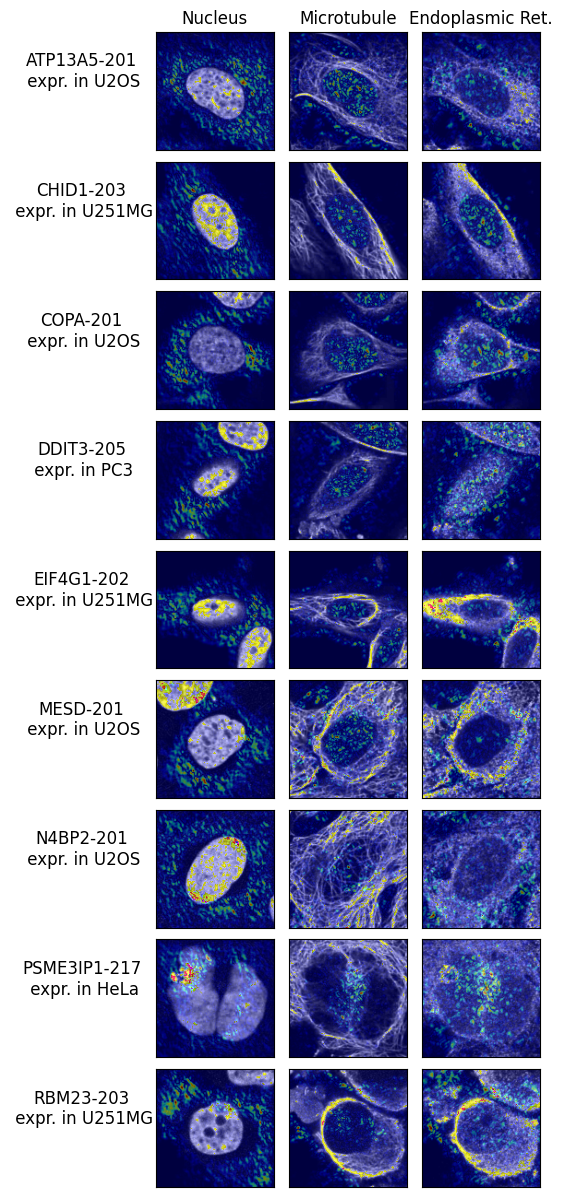

In [286]:
guided_model = replace_relu_with_guidedrelu(loaded_model)

viz_guided_gradients_on_fly(
    guided_model,
    proteoforms_of_interest,
    data_sources=data_sources
)

{'_id': 'train_11401', 'location_labels': 'Cytokinetic bridge,Nucleoplasm,Plasma membrane', 'splice_isoform_id': 'ATP13A5-201', 'cell_image': {'nuclei_channel': '/mnt/data0/yitongt/subcell_loc/images/ATP13A5-ENSG00000187527/single_cells_crops/U2OS_1978_H7_2_cell5_blue.tif', 'microtubule_channel': '/mnt/data0/yitongt/subcell_loc/images/ATP13A5-ENSG00000187527/single_cells_crops/U2OS_1978_H7_2_cell5_red.tif', 'antibody_channel': '/mnt/data0/yitongt/subcell_loc/images/ATP13A5-ENSG00000187527/single_cells_crops/U2OS_1978_H7_2_cell5_green.tif', 'mitochondria_channel': '/mnt/data0/yitongt/subcell_loc/images/ATP13A5-ENSG00000187527/single_cells_crops/U2OS_1978_H7_2_cell5_yellow.tif'}, 'gene': 'ENSG00000187527', 'splice_isoform': 'ENSP00000341942', 'cell_line': 'U2OS'}
{'_id': 'train_1939', 'location_labels': 'Nucleoplasm', 'splice_isoform_id': 'CHID1-203', 'cell_image': {'nuclei_channel': '/mnt/yitongt/subcell_loc/images/CHID1-ENSG00000177830/single_cells_crops/U251MG_520_H8_1_cell5_blue.tif'

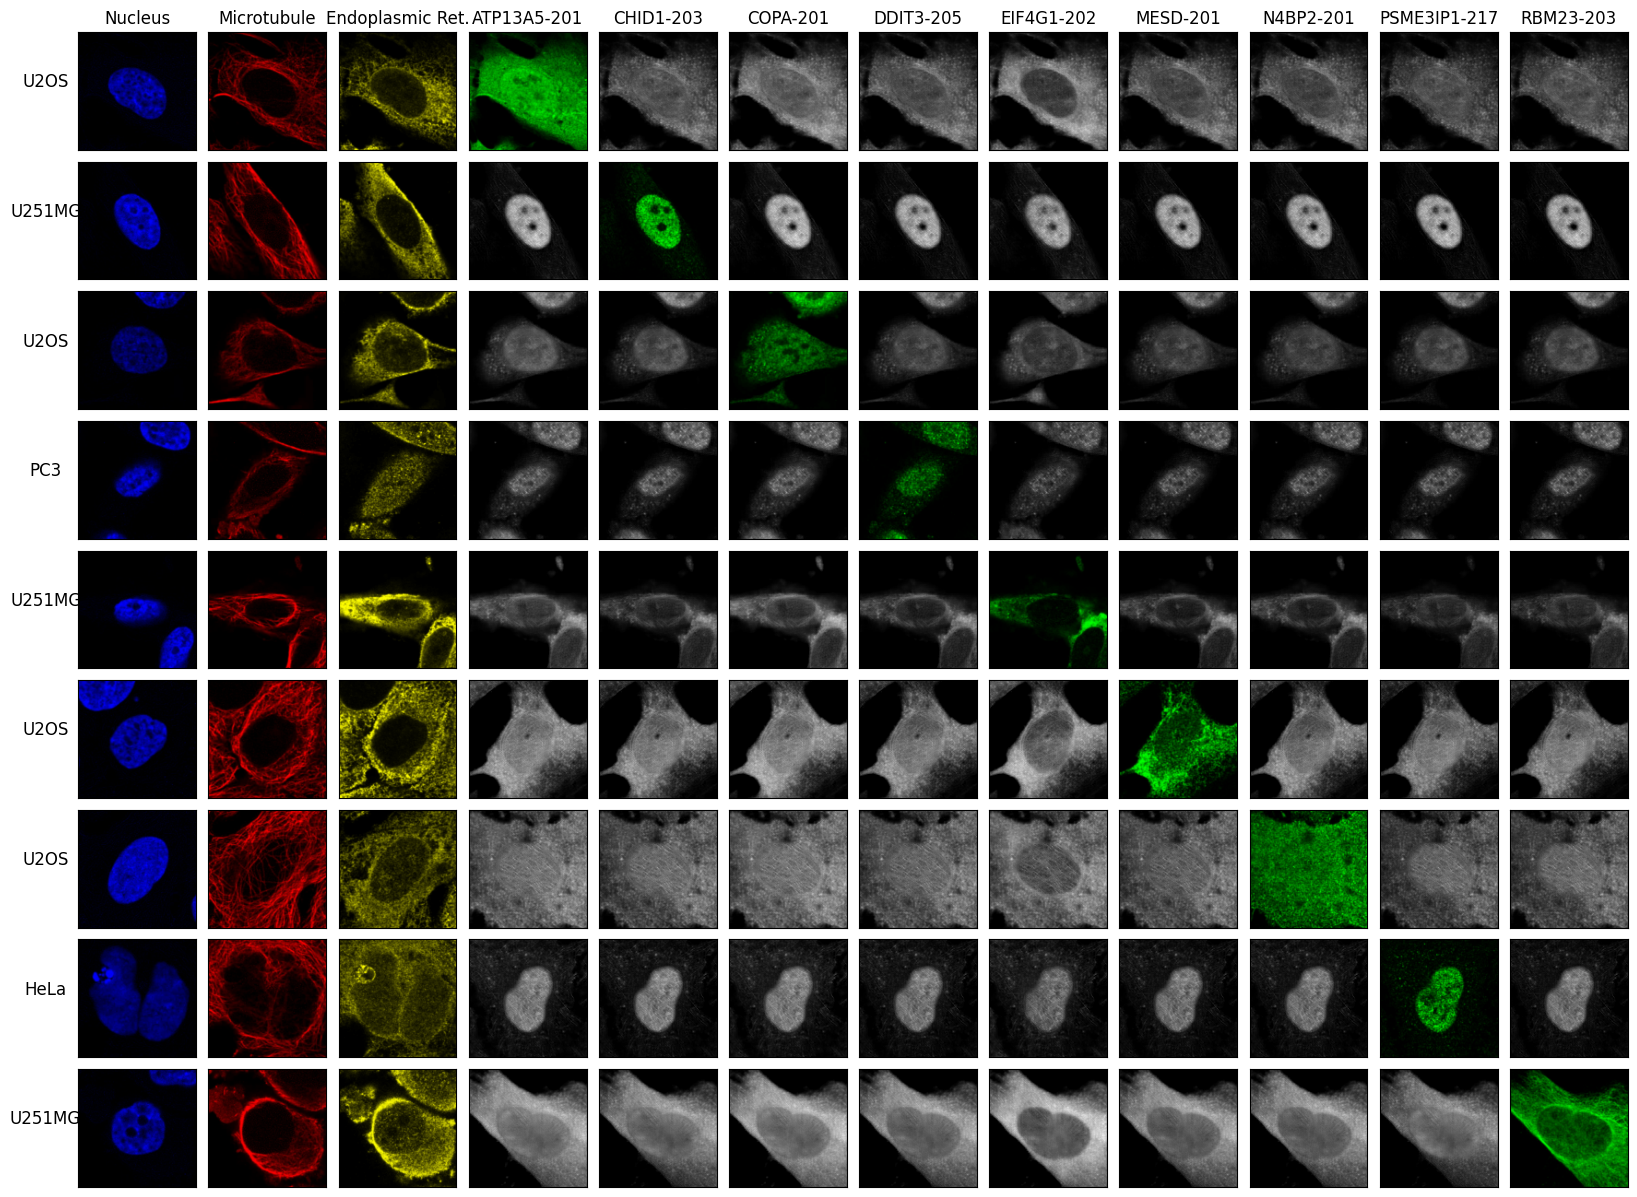

In [287]:
viz_matrix_on_fly(
    loaded_model,
    cell_idxs= proteoforms_of_interest,
    isoform_idxs= proteoforms_of_interest,
    figsize=(20, 15),
    show_y_true_on_diagonal=True,
    data_sources=data_sources
)

In [290]:
train_dataset.__del__()
val_dataset.__del__()
test_dataset.__del__()

Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
